Name: Saman Akhtar USC ID: 9944619932

**Imports**

In [1]:
from sklearn.cluster import KMeans
import os
import numpy as np
from keras.callbacks import Callback
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from keras.utils import np_utils
import tensorflow as tf
import tensorflow.keras.backend as bk
from tensorflow.keras.layers import Activation
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

# 2.(Deep) CNNs for Image Colorization

In [2]:
print("Num GPUs Available: ", 
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## (a) This assignment uses a convolutional neural network for image colorization whichturns a grayscale image to a colored image.By converting an image to grayscale,we loose color information, so converting a grayscale image back to a coloredversion is not an easy job. We will use the CIFAR-10 dataset. Download thedataset fromhttp://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [3]:
(trainX, trainy), (testX, testy) = keras.datasets.cifar10.load_data()


170500096/170498071 [==============================] - 6s 0us/step


In [4]:
trainX.shape

(50000, 32, 32, 3)

## (b) From the train and test dataset, extract the class birds. We will focus on this class, which has 6000 members.

Bird class is third class in Cifar-10 dataset


In [5]:
# Get the index of bird class(third class)
train_index, _ = np.where(trainy == 2)
test_index, _ = np.where(testy == 2)

# Extract bird class
train_birdX, train_birdy = trainX[train_index], trainy[train_index]
test_birdX, test_birdy = testX[test_index], testy[test_index]


In [6]:
train_birdX.shape

(5000, 32, 32, 3)

In [7]:
# Get Bird response and predictors
birdX = np.concatenate([train_birdX, test_birdX])
birdy = np.concatenate([train_birdy, test_birdy])


In [8]:
birdX.shape

(6000, 32, 32, 3)

In [9]:
birdy.shape

(6000, 1)

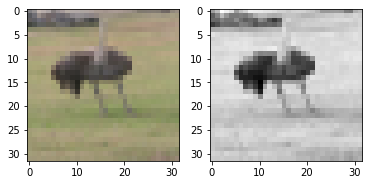

(32, 32)


In [10]:

fig, axes = plt.subplots(1, 2)
axes[0].imshow(birdX[5])

# Convert images from RGB to Grayscale.
axes[1].imshow(rgb2gray(birdX[5]), cmap='gray')
plt.show()
print(rgb2gray(birdX[5]).shape)

## (c) Those 6000 images have 6000×32×32 pixels. Choose at least 10% of the pixels randomly. It is strongly recommended that you choose a large number or all ofthe pixels. You will have betweenP= 614400 andP= 6144000 pixels. Eachpixel is an RGB vector with three elements.

Choosing 85 % of the pixel

In [11]:
per = 0.80
pixel = birdX.shape[0] * birdX.shape[1] * birdX.shape[2]
rand_len = int(pixel * per)
print("Lenghth of randomly selected pixels is:",rand_len)

Lenghth of randomly selected pixels is: 4915200


In [12]:
# Select index randomly
rand_idx = np.random.choice(pixel, rand_len)
img_idx = [idx // 1024 for idx in rand_idx]
row_idx = [idx % 1024 // 32 for idx in rand_idx]
col_idx = [idx % 1024 % 32 for idx in rand_idx]
pix_idx =  (img_idx, row_idx, col_idx)

In [13]:
random_pix = birdX[pix_idx]
print("Randomly selected ", per," pixels ndarray shape: ", random_pix.shape)
print(random_pix[:5])

Randomly selected  0.8  pixels ndarray shape:  (4915200, 3)
[[249 254 253]
 [157 152 134]
 [132 149 171]
 [ 46  45  42]
 [104  96  83]]


## (d) Run k-means clustering on thePvectors usingk= 4. The centers of the clusterswill be your main colors. Convert the colored images to k-color images by con-verting each pixel’s value to the closest main color in terms of Euclidean distance.These are the outputs of your network, whose each pixel falls in one of thosekclasses.

In [14]:
# Fitting K means using the randomly selected pixe;s
kmeans = KMeans(n_clusters = 4, random_state = 20).fit(random_pix) 
# clus_center = kmeans.cluster_centers_.astype(np.uint8())
# clus_center

In [15]:
center_clus = np.array([[0,0,128],
                                    [230,25,75],
                                    [170,255,195],
                                    [255,255,255]], dtype= np.uint8)
center_clus                        

array([[  0,   0, 128],
       [230,  25,  75],
       [170, 255, 195],
       [255, 255, 255]], dtype=uint8)

In [16]:
# Set cluster center to  Navy # Red # Mint # White colour
kmeans.cluster_centers_ = center_clus

color_birds = birdX.reshape((-1, 3))
pred_idx = kmeans.predict(color_birds)
for i in range(color_birds.shape[0]):
  color_birds[i] = np.copy(kmeans.cluster_centers_[pred_idx[i]])

color_birds = np.reshape(color_birds, birdX.shape)
print(color_birds.shape)

(6000, 32, 32, 3)


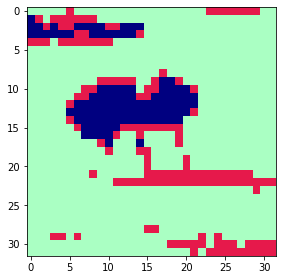

In [17]:
  plt.imshow(color_birds[5])
  plt.tight_layout()

## (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32×32×1 imagesfrom the original 32×32×3 images. The grayscale images are inputs of yournetwork.

In [18]:
# Using Scikilearn to convert images from RGB to Grayscale.
gray_birds = rgb2gray(birdX)

In [19]:
gray_birds.shape

(6000, 32, 32)

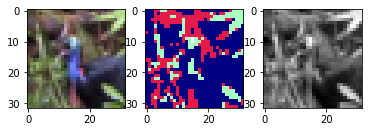

In [20]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(birdX[3])
axes[1].imshow(color_birds[3])
axes[2].imshow(gray_birds[3], cmap = 'gray')
plt.show()

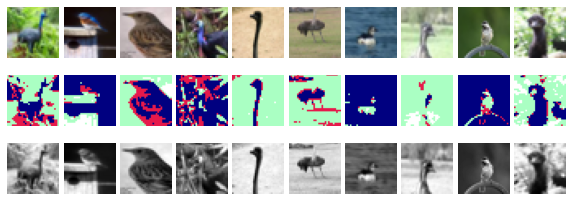

In [21]:
plt.figure(figsize=(10,15))

for i in range(1, 11, 1):
    
    # Original bird image
    plt.subplot(3,10,i)
    plt.imshow(birdX[i-1])
    plt.axis('off')
    
    # Kmean coloured burd
    plt.subplot(3,10,10+i)
    plt.imshow(color_birds[i-1])
    plt.axis('off')
    
    # Gray scaled bird
    plt.subplot(3,10,20+i)
    plt.imshow(gray_birds[i-1], cmap="gray")
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.1, hspace=-0.9)
plt.show()    

## f) Set up a deep convolutional neural network with two convolution layers (or more)and  two  (or  more)  MLP  layers.   Use  5×5  filters  and  a  softmax  output  layer.Determine the number of filters, strides, and whether or not to use padding your-self.  Use a minimum of one max pooling layer.  Use a classification scheme, whichmeans your output must determine one of thek= 4 color classes for each pixel inyour grayscale image.

In [22]:
# Adding batch axis
gray_birds = np.expand_dims(gray_birds, axis=-1)
gray_birds.shape

(6000, 32, 32, 1)

In [23]:
# Splitting
# Getting input for model : grayscaled images
gray_trainX = gray_birds[:5000]
gray_testX = gray_birds[5000:]
print(gray_trainX.shape)
print(gray_testX.shape)

(5000, 32, 32, 1)
(1000, 32, 32, 1)


In [24]:
# Pre - processing 

gray_trainX = gray_trainX.astype('float32') / 255
gray_testX =  gray_testX.astype('float32') /  255

In [25]:
color_birds.shape

(6000, 32, 32, 3)

In [26]:
pred_idx.shape

(6144000,)

In [27]:
onehot_clr = np_utils.to_categorical(pred_idx)
print(onehot_clr.shape)

(6144000, 4)


In [28]:
# Getting output for the model: tetrachrome  images
onehot_clr = onehot_clr.reshape((6000, 4096)) # 1024 * 4)
tetra_trainy = onehot_clr[:5000].reshape((-1, 4096))
tetra_testy = onehot_clr[5000:].reshape((-1, 4096))

In [29]:
print(tetra_trainy.shape)
print(tetra_testy.shape)

(5000, 4096)
(1000, 4096)


In [133]:
# Convolution layers and MLP  layers
def CNNetwork():
    cnn_model = Sequential()
    
    # Convolutional
    cnn_model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', input_shape=(32,32,1), activation='relu'))
    cnn_model.add(Conv2D(filters=64, kernel_size=(5,5), padding='same', activation='relu'))

    # Adding max pooling layer
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Conv2D(filters=128, kernel_size=(5,5), padding='same', activation='relu'))

    # Adding another max pooling layer
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))    
    cnn_model.add(Dropout(0.2))
    cnn_model.add(Conv2D(filters= 256, kernel_size=(5,5), padding='same', activation='relu'))

    # MLP
    cnn_model.add(Flatten())
    cnn_model.add(Dense(8192, activation='relu'))
    cnn_model.add(Dense(4096, activation='relu'))

    # Softmax layer
    cnn_model.add(Activation('softmax'))
    return cnn_model

In [134]:
cnnmodel = CNNetwork()

In [135]:
print(cnnmodel.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1664      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 8, 128)        

In [136]:
# Configuring models learning process with .compile():
cnnmodel.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [137]:
test_loss = []
class callCheckpoint(Callback):
    
    def on_epoch_end(self, epoch, logs={}):
      # record a test loss
        scores = self.model.evaluate(gray_testX, tetra_testy, verbose=1)
        test_loss.append(scores)

        # Set callback
        filepath = "./CNNWeights/weights-improvement-{epoch:02d}-{loss:.2f}-bigger.hdf5"
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        #callbacks_weight = [checkpoint]

In [138]:
# fit the model
birdcnn  = cnnmodel.fit(gray_trainX, tetra_trainy, validation_split=0.2, batch_size=128, 
                    epochs = 50, verbose=1, callbacks=[callCheckpoint()])

Epoch 1/50
32/32 [==============================] - 0s 9ms/step - loss: 20509714432.0000
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 6657862008832.0000
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 237800997781504.0000
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 2922301116907520.0000
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 19544272302768128.0000
Epoch 6/50
32/32 [==============================] - 0s 7ms/step - loss: 88560937153331200.0000
Epoch 7/50
32/32 [==============================] - 0s 7ms/step - loss: 307122769055711232.0000
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 875666109926211584.0000
Epoch 9/50
32/32 [==============================] - 0s 8ms/step - loss: 2155952911190851584.0000
Epoch 10/50
32/32 [==============================] - 0s 8ms/step - loss: 4759306449572593664.0000
Epoch 11/50
32/32 [==============================] - 0s 

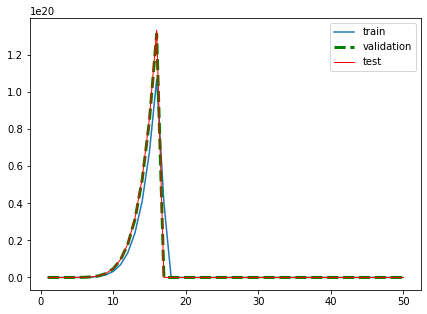

In [141]:
# plot loss curves
epoch = 50
train_loss = birdcnn.history['loss']
valid_loss = birdcnn.history['val_loss']

fig, axes = plt.subplots(figsize=(7, 5))
axes.plot(range(1, epoch + 1), train_loss, label='train')
axes.plot(range(1, epoch + 1), valid_loss, label='validation',linestyle='--', color='green', linewidth= 3)
axes.plot(range(1, len(test_loss) + 1), test_loss, label='test', color='red', linewidth=1)
axes.legend()
plt.show()

In [142]:
predy = cnnmodel.predict(gray_testX[:10])
predy = np.reshape(predy, (10, 32, 32, 4))
predy = np.argmax(predy, axis=-1)
print(predy.shape)
k_predy = kmeans.cluster_centers_[predy]
print(k_predy.shape)

(10, 32, 32)
(10, 32, 32, 3)


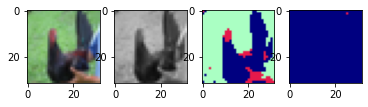

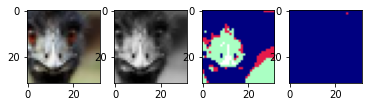

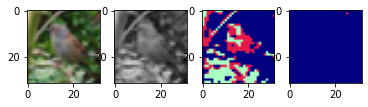

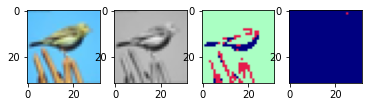

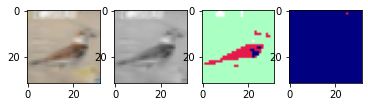

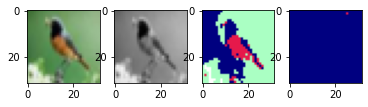

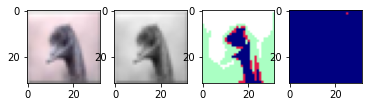

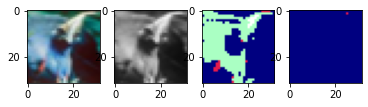

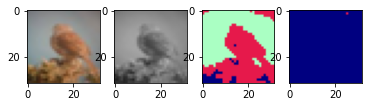

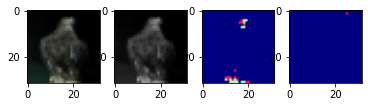

In [132]:

for i in range(10):
  fig, axes = plt.subplots(1, 4)
  axes[0].imshow(birdX[5000 + i])
  axes[1].imshow(np.stack((gray_testX[ i, :, :, 0] * 255, ) * 3, axis=-1), cmap='gray')
  axes[2].imshow(color_birds[5000 + i])
  axes[3].imshow(k_predy[i])
  plt.show()

**References**

https://www.tensorflow.org/api_docs/python/tf/image/rgb_to_grayscale
https://towardsdatascience.com/convolution-neural-network-for-image-processing-using-keras-dc3429056306
https://emilwallner.medium.com/colorize-b-w-photos-with-a-100-line-neural-network-53d9b4449f8d
https://keras.io/api/callbacks/
https://stackoverflow.com/questions/66218328/mnist-cnn-valueerror-expected-min-ndim-4-found-ndim-3-full-shape-received-32